In [6]:
# standard library
import os

import pandas as pd
import seaborn as sns
import numpy as np
from highstreets.data import make_dataset as mhsd
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt

import numpyro
from numpyro.infer import MCMC, NUTS, Predictive, init_to_feasible
from numpyro.infer.reparam import TransformReparam
import numpyro.distributions as dist
from jax import random
import arviz as az

import dill

assert numpyro.__version__.startswith("0.9.2")

load_dotenv(find_dotenv())

YOY_FILE = os.environ.get("YOY_FILE")
PROFILE_FILE = os.environ.get("PROFILE_FILE")
PROJECT_ROOT = os.environ.get("PROJECT_ROOT")

%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")
sns.set_context("notebook")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load mastercard spend data along with high street profiles and setup data arrays and time vectors for convenience


In [9]:
hsp = pd.read_excel(PROFILE_FILE)
hsd_yoy = pd.read_csv(YOY_FILE, parse_dates=["week_start"])

# some important dates
nb_dates = pd.to_datetime(
    [
        "2020-03-24",  # first lockdown starts
        "2020-06-15",  # shops reopen
        "2020-11-05",  # second lockdown starts
        "2020-12-02",  # back to 'tier 2' (i.e. partial reopening)
        "2021-01-05",  # third lockdown starts
        "2021-04-12",  # shops reopen
    ]
)

# average weekday and weekend expenditure (should probably relax this
# later - no need to lose information)
hsd_yoy_minimal = mhsd.avg_retail_wd_we(hsd_yoy, "yoy_").dropna(how="any", axis="rows")

dates_2020 = ("2020-04-15", "2020-10-31")
dates_2020_full = ("2020-01-01", "2020-12-31")
dates_2021 = ("2021-02-12", "2021-08-31")
dates_full = ("2020-01-01", "2021-12-31")

data_2020 = mhsd.extract_data_array(hsd_yoy_minimal, dates_2020, "txn_amt")
data_2021 = mhsd.extract_data_array(hsd_yoy_minimal, dates_2021, "txn_amt")
data_2020_full = mhsd.extract_data_array(hsd_yoy_minimal, dates_2020_full, "txn_amt")
data_full = mhsd.extract_data_array(hsd_yoy_minimal, dates_full, "txn_amt")

start_times = {"2020": "2020-04-01", "2021": "2021-04-12", "full": "2020-04-01"}
tvecs = {"2020": data_2020.index, "2021": data_2021.index, "full": data_full.index}
arrays = {
    "2020": np.transpose(data_2020.to_numpy()),
    "2021": np.transpose(data_2021.to_numpy()),
    "full": np.transpose(data_full.to_numpy()),
}

### Set up data to be used in hierarcical regressions

In [10]:
predictors = [
    "percentage of commercial addresses (%)",
    "total estimated number of home workers",
    "Sum_y2019_07wd",
]
full_data = (
    hsd_yoy_minimal.join(
        hsp[["highstreet_id"] + predictors],
        on="highstreet_id",
        how="left",
        lsuffix="_left",
        rsuffix="_right",
    )
    .drop(["highstreet_id_right", "txn_cnt"], axis=1)
    .rename(columns={"highstreet_id_left": "highstreet_id"})
)
full_data["weeks_since_start"] = (
    full_data.index - pd.to_datetime(nb_dates[0])
) / pd.Timedelta(1, "W")
train = full_data.loc[nb_dates[0] : nb_dates[1]]
train.head()

,week_start,highstreet_id,highstreet_name,txn_amt,percentage of commercial addresses (%),total estimated number of home workers,Sum_y2019_07wd,weeks_since_start
week_start,,,,,,,,
2020-03-30,2020-03-30,1,"Pimlico Road, Belgravia",0.039,10.004793,10374.0,7354.840627,0.857143
2020-03-30,2020-03-30,2,"Queensway, Westbourne Grove, Bayswater",0.198,6.657224,4388.0,1141.060698,0.857143
2020-03-30,2020-03-30,3,"Carshalton Road, Carshalton.",0.000,3.311258,3632.0,1410.542551,0.857143
2020-03-30,2020-03-30,4,"Mitcham Road, Croydon.",1.297,8.472856,2879.0,2159.100879,0.857143
2020-03-30,2020-03-30,5,"Bridge Road, Chessington.",0.000,7.789256,3672.0,2693.808580,0.857143


### Define hierarchical regression model

In [11]:
def model(highstreet_id, weeks, hs_obs=None):
    mu_a = numpyro.sample("mu_a", dist.Normal(0.0, 1.0))
    sigma_a = numpyro.sample("sigma_a", dist.HalfNormal(1.0))
    mu_b = numpyro.sample("mu_b", dist.Normal(0.0, 1.0))
    sigma_b = numpyro.sample("sigma_b", dist.HalfNormal(1.0))

    unique_hs_ids = np.unique(highstreet_id)
    n_hs = len(unique_hs_ids)

    with numpyro.plate("plate_i", n_hs):
        a = numpyro.sample("a", dist.Normal(mu_a, sigma_a))
        b = numpyro.sample("b", dist.Normal(mu_b, sigma_b))

    sigma = numpyro.sample("sigma", dist.HalfNormal(1.0))
    hs_est = a[highstreet_id] + b[highstreet_id] * weeks

    with numpyro.plate("data", len(highstreet_id)):
        numpyro.sample("obs", dist.Normal(hs_est, sigma), obs=hs_obs)

### Define non-centered version of the same model 

In [12]:
def model_noncentered(highstreet_id, weeks, hs_obs=None):
    mu_a = numpyro.sample("mu_a", dist.Normal(0.0, 1.0))
    sigma_a = numpyro.sample("sigma_a", dist.HalfNormal(1.0))
    mu_b = numpyro.sample("mu_b", dist.Normal(0.0, 1.0))
    sigma_b = numpyro.sample("sigma_b", dist.HalfNormal(1.0))

    unique_hs_ids = np.unique(highstreet_id)
    n_hs = len(unique_hs_ids)

    with numpyro.plate("plate_i", n_hs):
        with numpyro.handlers.reparam(
            config={
                "a": TransformReparam(),
                "b": TransformReparam(),
            }
        ):
            a = numpyro.sample(
                "a",
                dist.TransformedDistribution(
                    dist.Normal(0.0, 1.0),
                    dist.transforms.AffineTransform(mu_a, sigma_a),
                ),
            )
            b = numpyro.sample(
                "b",
                dist.TransformedDistribution(
                    dist.Normal(0.0, 1.0),
                    dist.transforms.AffineTransform(mu_b, sigma_b),
                ),
            )

    sigma = numpyro.sample("sigma", dist.HalfNormal(1.0))
    hs_est = a[highstreet_id] + b[highstreet_id] * weeks

    with numpyro.plate("data", len(highstreet_id)):
        numpyro.sample("obs", dist.Normal(hs_est, sigma), obs=hs_obs)

In [13]:
hs_obs = train["txn_amt"].values
weeks = train["weeks_since_start"].values
highstreet_id = train["highstreet_id"].values

### Sample from the posterior

In [14]:
nuts_kernel = NUTS(model, init_strategy=init_to_feasible())

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, highstreet_id, weeks, hs_obs=hs_obs)
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [08:25<00:00,  7.91it/s, 1023 steps of size 1.08e-03. acc. prob=0.77]


#### Save the model samples

In [16]:
dill_file = PROJECT_ROOT + "/models/bayesian/posterior_samples_basic.pkl"
with open(dill_file, "wb") as f:
    dill.dump(
        posterior_samples,
        f,
    )

In [19]:
nuts_kernel_noncentered = NUTS(model_noncentered, init_strategy=init_to_feasible())

mcmc_noncentered = MCMC(nuts_kernel_noncentered, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc_noncentered.run(rng_key, highstreet_id, weeks, hs_obs=hs_obs)

posterior_samples_noncentered = mcmc_noncentered.get_samples()

sample: 100%|██████████| 4000/4000 [08:30<00:00,  7.84it/s, 1023 steps of size 9.10e-04. acc. prob=0.78]


In [20]:
dill_file = PROJECT_ROOT + "/models/bayesian/posterior_samples_noncentered_basic.pkl"
with open(dill_file, "wb") as f:
    dill.dump(
        posterior_samples_noncentered,
        f,
    )

### Load previous samples

In [17]:
dill_file = PROJECT_ROOT + "models/bayesian/posterior_samples_basic.pkl"
with open(dill_file, "rb") as f:
    posterior_samples_loaded = dill.load(f)

### Trace plot for centered model

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>]], dtype=object)

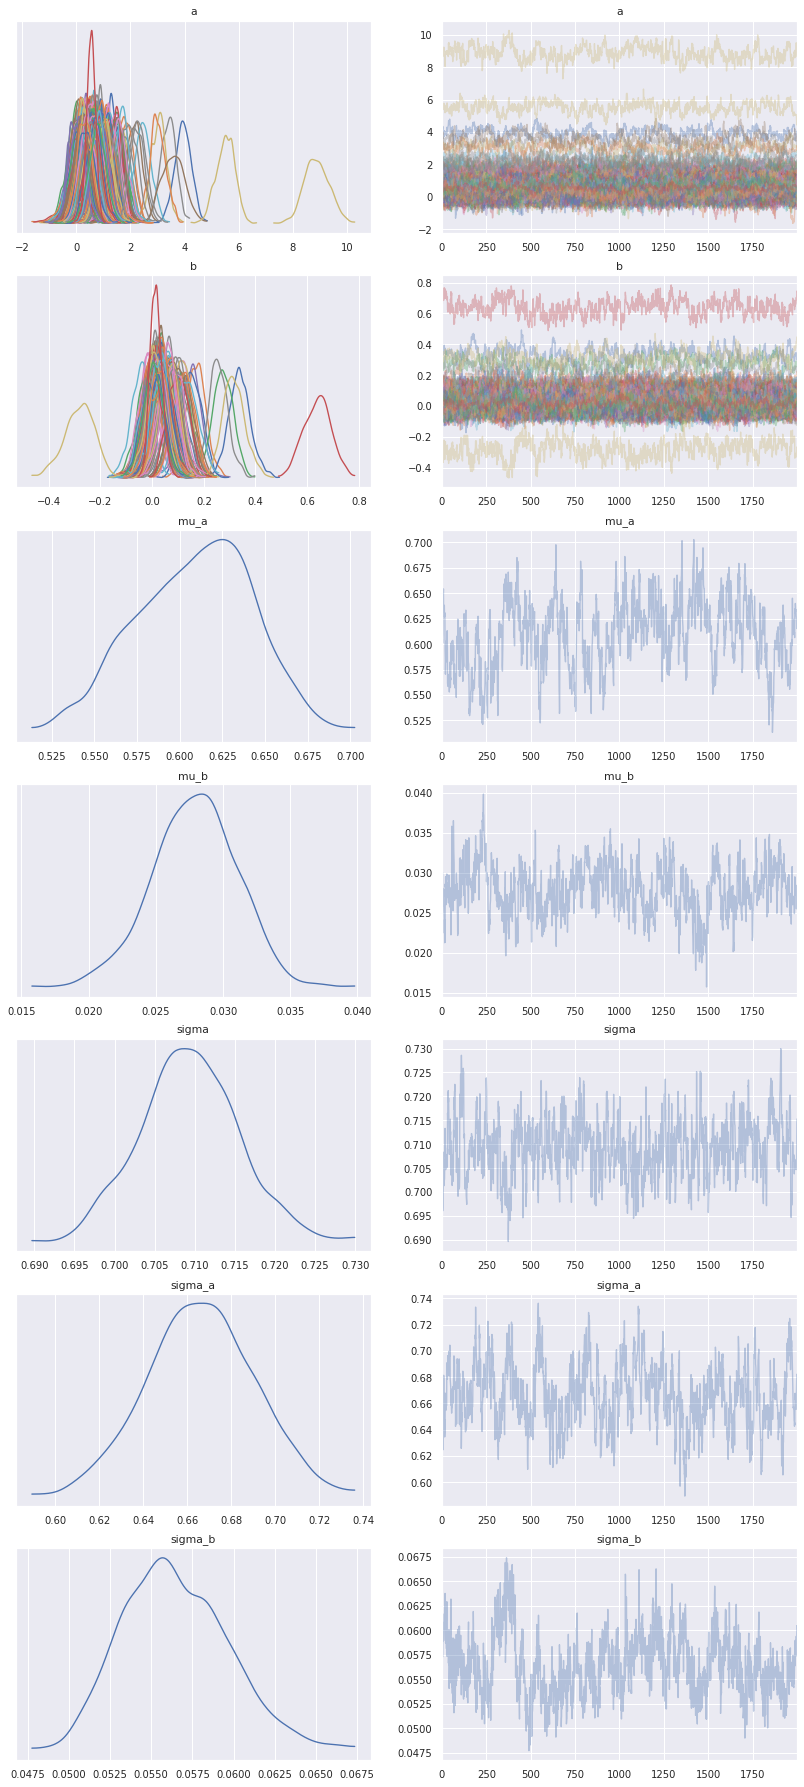

In [21]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(14, 32))

### Trace plot for unnoncentered model

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'a_base'}>,
        <AxesSubplot:title={'center':'a_base'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'b_base'}>,
        <AxesSubplot:title={'center':'b_base'}>],
       [<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>]], dtype=object)

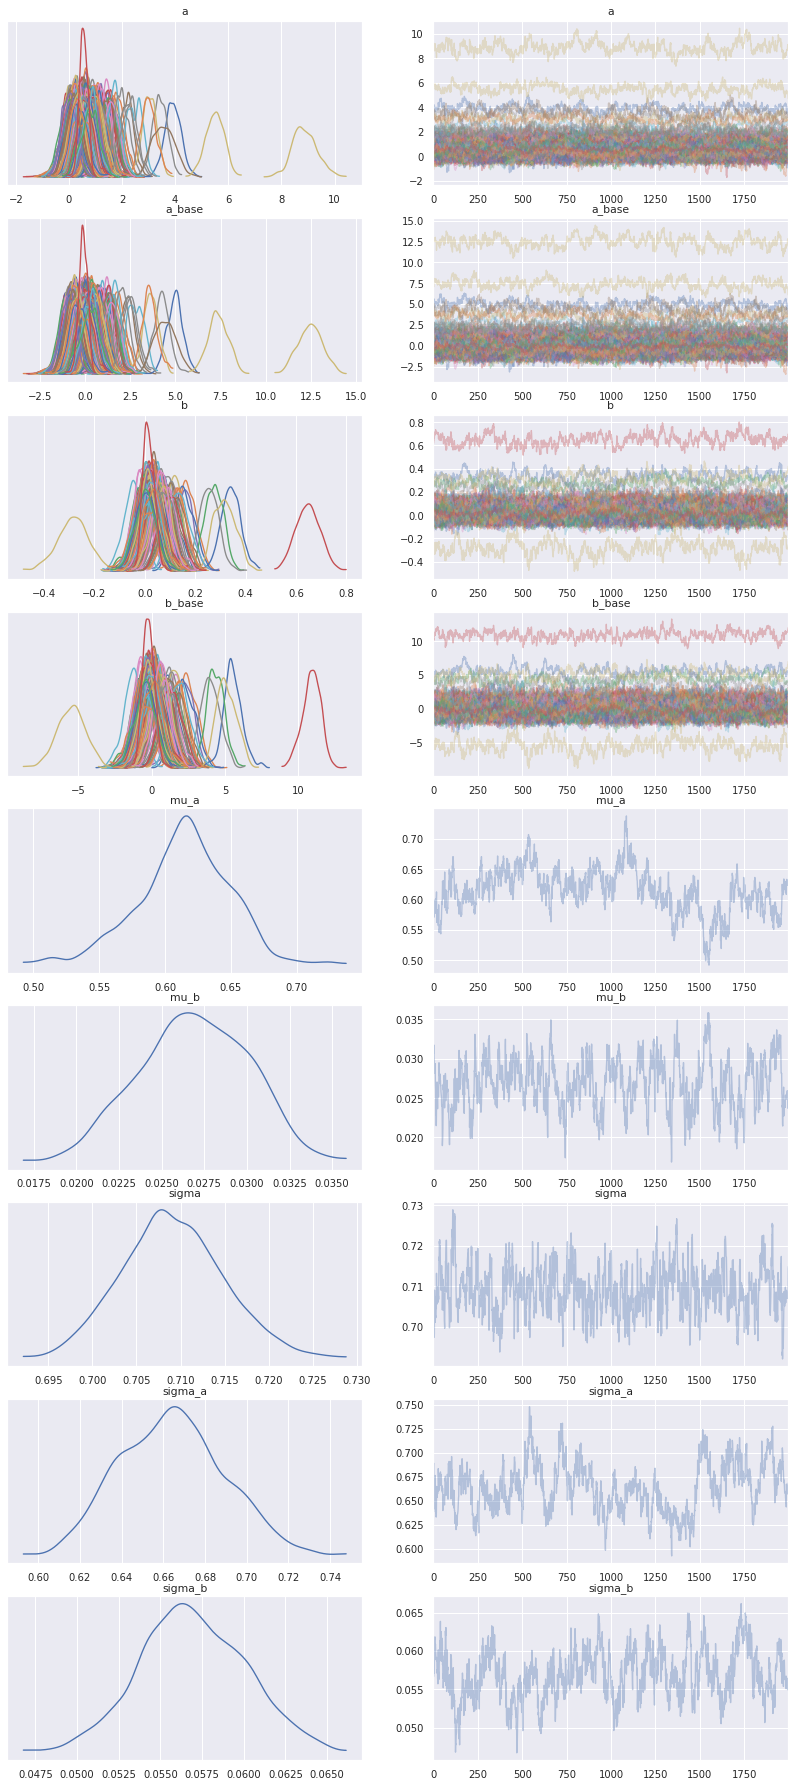

In [22]:
data_noncentered = az.from_numpyro(mcmc_noncentered)
az.plot_trace(data_noncentered, compact=True, figsize=(14, 32))

### Examine model output

In [47]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      0.63      0.67      0.58     -0.40      1.77    122.33      1.00
      a[1]      0.17      0.32      0.17     -0.38      0.66     56.82      1.01
      a[2]      0.17      0.31      0.17     -0.32      0.71    108.59      1.00
      a[3]      0.05      0.30      0.06     -0.47      0.51     69.03      1.01
      a[4]      1.16      0.28      1.15      0.73      1.62     97.96      1.02
      a[5]      0.34      0.29      0.35     -0.14      0.78    149.64      1.01
      a[6]      0.37      0.28      0.36     -0.08      0.81     87.90      1.02
      a[7]      0.20      0.28      0.21     -0.24      0.71     36.24      1.00
      a[8]      0.52      0.30      0.51      0.01      0.97     71.67      1.01
      a[9]      0.64      0.28      0.65      0.16      1.07     88.93      1.03
     a[10]      0.55      0.29      0.54      0.08      1.06     87.57      1.00
     a[11]      0.27      0

In [24]:
mcmc_noncentered.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  a_base[0]      0.01      1.06     -0.06     -1.78      1.63     97.05      1.01
  a_base[1]     -0.61      0.49     -0.63     -1.33      0.31     41.14      1.03
  a_base[2]     -0.66      0.46     -0.64     -1.37      0.16     78.59      1.00
  a_base[3]     -0.85      0.44     -0.80     -1.57     -0.14     54.88      1.05
  a_base[4]      0.85      0.44      0.83      0.12      1.52     78.47      1.01
  a_base[5]     -0.41      0.42     -0.42     -1.09      0.29    114.30      1.01
  a_base[6]     -0.40      0.40     -0.42     -0.99      0.27     82.56      1.00
  a_base[7]     -0.60      0.45     -0.62     -1.28      0.19     21.34      1.00
  a_base[8]     -0.12      0.44     -0.11     -0.86      0.58     63.82      1.00
  a_base[9]      0.03      0.44      0.03     -0.72      0.70     30.03      1.03
 a_base[10]     -0.09      0.44     -0.11     -0.79      0.68     59.32      1.00
 a_base[11]    

### Compare predictions to data

In [27]:
weeks_pred = train[train["highstreet_id"] == 1]["weeks_since_start"]
pred_template = []
for i in np.unique(train["highstreet_id"]):
    df = pd.DataFrame(columns=["highstreet_id", "weeks"])
    df["weeks"] = weeks_pred
    df["highstreet_id"] = i
    pred_template.append(df)
pred_template = pd.concat(pred_template, ignore_index=True)

highstreet_id = pred_template["highstreet_id"].values
weeks = pred_template["weeks"].values
predictive = Predictive(model, posterior_samples, return_sites=["sigma", "obs"])
samples_predictive = predictive(random.PRNGKey(0), highstreet_id, weeks, None)

df = pd.DataFrame(
    columns=["highstreet_id", "weeks_since_start", "txn_amt_pred", "sigma"]
)
df["highstreet_id"] = pred_template["highstreet_id"]
df["weeks_since_start"] = pred_template["weeks"]
df["txn_amt_pred"] = samples_predictive["obs"].T.mean(axis=1)
df["sigma"] = samples_predictive["obs"].T.std(axis=1)
df["hs_inf"] = df["txn_amt_pred"] - df["sigma"]
df["hs_sup"] = df["txn_amt_pred"] + df["sigma"]
df = pd.merge(
    df,
    train[["highstreet_id", "weeks_since_start", "txn_amt"]],
    how="left",
    on=["highstreet_id", "weeks_since_start"],
)
df = df.rename(columns={"txn_amt": "txn_amt_true"})
df.head()

,highstreet_id,weeks_since_start,txn_amt_pred,sigma,hs_inf,hs_sup,txn_amt_true
0,1,0.857143,0.115556,0.795863,-0.680307,0.911419,0.0390
1,1,1.857143,0.143564,0.756480,-0.612916,0.900044,0.0505
2,1,2.857143,0.145775,0.755248,-0.609474,0.901023,0.0370
3,1,3.857143,0.157702,0.744515,-0.586813,0.902217,0.0365
4,1,4.857143,0.145888,0.716983,-0.571095,0.862871,0.0420


In [45]:
samples_predictive["obs"].T.mean(axis=1)

DeviceArray([0.11555586, 0.14356402, 0.1457747 , ..., 0.72712904,
             0.74208564, 0.7083444 ], dtype=float32)

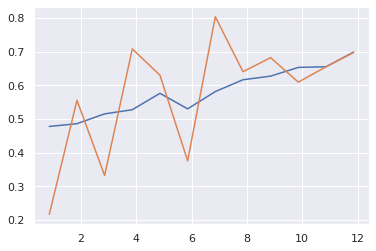

In [77]:
n = 25
data_n = df[df["highstreet_id"] == n]
plt.plot(data_n["weeks_since_start"], data_n["txn_amt_pred"])
plt.plot(data_n["weeks_since_start"], data_n["txn_amt_true"])

In [102]:
a_mean_pred = float(data.posterior.mu_a.mean())

In [103]:
a_mean_pred

0.6090134382247925

In [116]:
a_means = data.posterior.a.mean(axis=1).to_numpy().flatten()

(array([ 7., 47., 64., 83., 76., 79., 77., 46., 47., 24., 17., 11.,  4.,
         7.,  8.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.]),
 array([-0.08343094,  0.02860891,  0.14064875,  0.25268862,  0.36472845,
         0.4767683 ,  0.5888082 ,  0.700848  ,  0.81288785,  0.9249277 ,
         1.0369675 ,  1.1490074 ,  1.2610472 ,  1.373087  ,  1.485127  ,
         1.5971668 ,  1.7092066 ,  1.8212465 ,  1.9332863 ,  2.0453262 ,
         2.157366  ,  2.2694058 ,  2.3814456 ,  2.4934857 ,  2.6055255 ,
         2.7175653 ,  2.829605  ,  2.941645  ,  3.0536847 ,  3.1657248 ,
         3.2777646 ,  3.3898044 ,  3.5018442 ,  3.613884  ,  3.725924  ,
         3.8379638 ,  3.9500036

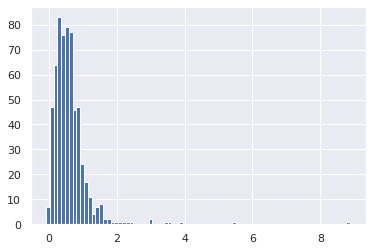

In [120]:
plt.hist(a_means, 80)

In [114]:
a_means.flatten().shape

(614,)